In [1]:
versioninfo()

Julia Version 1.9.1
Commit 147bdf428c (2023-06-07 08:27 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 2 on 6 virtual cores
Environment:
  JULIA_PYTHONCALL_EXE = python


In [2]:
using LinearAlgebra
using Random
using PyPlot
using MatrixDepot

include("expm_de.jl")

[ Info: verify download of index files...
[ Info: reading database
[ Info: adding metadata...
[ Info: adding svd data...
[ Info: writing database
[ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index


expm_de (generic function with 2 methods)

In [3]:
A_list = []
Ref_list = []

Random.seed!(1)
n = 50
Z = convert(Matrix{BigFloat}, mdopen("randsvd", n, 100).A)
for k = 1:2
    λ = [1 - 10^(2k*(i-1)/n-1) + randn()/20*im for i=1:n]
    D = Diagonal(λ)
    A = convert(Matrix{ComplexF64}, (Z * D) / Z)
    Ref = convert(Matrix{ComplexF64}, (Z * exp(D)) / Z)
    push!(A_list, A)
    push!(Ref_list, Ref)
end

In [4]:
include("expm_de.jl")
log10ϵ_list = collect(-10:0.5:-6)
results1 = Dict("x" => 10.0 .^ log10ϵ_list)
for k = 1:2
    A = A_list[k]
    Ref = Ref_list[k]
    λ = eigvals(A)
    i_right = argmax(real(λ))
    λ_right = λ[i_right]

    h0 = 1.0

    err_list = zero(log10ϵ_list)
    for (i, log10ϵ) in enumerate(log10ϵ_list)
        ϵ = 10.0 ^ (log10ϵ)
        r = expm_de(A, ϵ=ϵ/2, h0=h0, λ_right=λ_right)
        X = convert(Matrix{ComplexF64}, r.X)
        err_list[i] = opnorm(Ref - X)
    end
    results1["y$(k)"] = err_list
end

In [5]:
results2 = Dict()
k = 1
A = A_list[k]
Ref = Ref_list[k]
λ = eigvals(A)
i_right = argmax(real(λ))
λ_right = λ[i_right]

h0 = 1.0
ϵ = 1e-10
result = expm_de(A, ϵ=ϵ, h0=h0, λ_right=λ_right)

results2["x"] = 1 ./ result.h
results2["y1"] = result.errest

err_list = []
for (h, l, r) in zip(result.h, result.l, result.r)
    r = expm_de(A, h, ϵ=ϵ/2, λ_right=λ_right, lr=[l,r])
    X = convert(Matrix{ComplexF64}, r.X)
    push!(err_list, opnorm(X - Ref))
end
results2["y2"] = err_list;

In [6]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 8
rcParams["axes.titlesize"] = 8

8

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


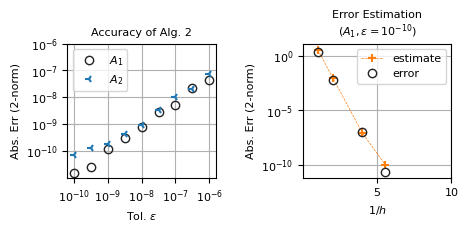

In [7]:
x1 = results1["x"]
y11 = results1["y1"]
y12 = results1["y2"]

x2 = results2["x"]
y21 = results2["y1"]
y22 = results2["y2"]

fig, ax = subplots(1, 2, figsize=[12,6]/2.54)
ax[1].plot(x1, y11, marker="o", markerfacecolor="none", lw=0, c="#222222", label="\$A_1\$")
ax[1].plot(x1, y12, marker="3", lw=0, c="tab:blue", markeredgewidth=1.5, label="\$A_2\$")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax[1].set_yticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax[1].set_xlabel("Tol. \$\\epsilon\$")
ax[1].set_ylabel("Abs. Err (2-norm)")
ax[1].set_title("Accuracy of Alg. 2")
ax[1].legend()
ax[1].grid()

ax[2].plot(x2, y21, marker="+", c="tab:orange", markeredgewidth=1.5, lw=0.5, ls="--", label="estimate")
ax[2].plot(x2, y22, marker="o", markerfacecolor="none", lw=0, c="#222222", label="error")
ax[2].set_yscale("log")
ax[2].set_xlim(0,6)
ax[2].set_xticks([5, 10])
ax[2].set_yticks([1e-10, 1e-5, 1e0])
ax[2].set_xlabel("\$1/h\$")
ax[2].set_ylabel("\nAbs. Err (2-norm)")
ax[2].set_title("Error Estimation\n\$(A_1, \\epsilon=10^{-10})\$")
ax[2].legend()
ax[2].grid()

fig.tight_layout()
fig.savefig("fig/test3.pdf")
show()